# Capstone Project 1
# Lending Club Loan Status Analysis
## Part 4: Modelling Loan Status: Machine Learning Approach

Data Source: Kaggle Dataset -- Lending Club Loan Data  
URL: https://www.kaggle.com/wendykan/lending-club-loan-data  
Analyst: Eugene Wen

In [2]:
# Load the cleaned dataset from previous steps.
%run ./py/FE.py
%matplotlib inline

In [3]:
# Quickly check the dataframe loaded in.
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 33 columns):
funded_amnt                    887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
annual_inc                     887379 non-null float64
verification_status            887379 non-null object
purpose                        887379 non-null object
addr_state                     887379 non-null object
dti                            887379 non-null float64
delinq_2yrs                    887379 non-null float64
inq_last_6mths                 887379 non-null float64
mths_since_last_delinq         887379 non-null float64
mths_since_last_record         887379 non-null float64
open_acc                       887379 non-null float64
pub_rec                        887379 non-null float64
revol_bal                      887379 non-null float64
revol_util                     887379 non-null float64
total_acc    

### Training and Test Set Preparation
As we have seen in the previous section, the target (loan_status_simple) is not balaced and including a level Issued that needs to be removed from the target. This level, however, could be used as new data for prediction. 

For convenience, we will take the following steps to prepare the training, test and prediction sets:  
1. Use custom functions to conduct standardization and dummy coding on the dataframe.
2. Split status = Issued as predict set. Undersample status = Good observations to 10% (yield 81149 rows) and append to status = Bad to form train_test_set.
3. Split the train_test_set into X_train, y_train, X_test and y_test for further modeling.

In [4]:
import pandas as pd
import numpy as np
# Define std_scaler that takes a dataframe and standardize all numerical columns.
# Return updated dataframe.
def std_scaler(df):
    cols = df.select_dtypes(include=["float64"]).columns.tolist()
    for col in cols: 
        df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
    return df
    
# Define dummy_encoder that takes a dataframe and generate (k-1) dummy columns  for all categorical columns.
# Return updated dataframe.
def dummy_encoder(df):
    cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis = 1, inplace = True)
    return df

In [62]:
# Create a copy of loan dataframe
loan_copy = loan.copy()

In [63]:
# Process the dataframe using custom functions
loan_copy = std_scaler(loan_copy)
loan_copy = dummy_encoder(loan_copy)

In [69]:
# Undersampling the large category by 10%
loan_pred = loan_copy.loc[loan_copy.loan_status_simple_Issued == 1, ]
loan_pred.drop(["loan_status_simple_Good", "loan_status_simple_Issued"], axis = 1, inplace=True)

loan_bad = loan_copy.loc[(loan_copy.loan_status_simple_Good == 0) & (loan_copy.loan_status_simple_Issued == 0), ]
loan_bad["isBad"] = (loan_bad.loan_status_simple_Good == 0)
loan_bad.drop(["loan_status_simple_Issued", "loan_status_simple_Good"], axis = 1, inplace=True)

loan_good = loan_copy.loc[loan_copy.loan_status_simple_Good == 1, ].sample(frac=0.1)
loan_good["isBad"] = (loan_good.loan_status_simple_Good == 0)
loan_good.drop(["loan_status_simple_Issued", "loan_status_simple_Good"], axis = 1, inplace=True)

loan_train_test = pd.concat([loan_good, loan_bad], axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys

In [9]:
# Split the dataframe
from sklearn.model_selection import train_test_split
all_features = loan_train_test.columns.drop("isBad").tolist()
X_train, X_test, y_train, y_test = train_test_split(loan_train_test[all_features], loan_train_test["isBad"], test_size = 0.3, random_state = 1234) 

### First Model


In [10]:
# Extra Tree Classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
predictions = etc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.791161956034


In [11]:
# Feature Importance
feature_importance = pd.Series(etc.feature_importances_, index=all_features).sort_values(ascending=False)
print("Feature importance based on Extra Tree Classifier:")
print("**************************************************")
print(feature_importance)

Feature importance based on Extra Tree Classifier:
**************************************************
out_prncp                              0.119846
last_pymnt_amnt                        0.076498
int_rate                               0.061714
recoveries                             0.060425
total_pymnt                            0.046205
funded_amnt                            0.032966
total_rec_int                          0.030927
revol_util                             0.024894
cr_hist_yr                             0.024842
tot_cur_bal                            0.023298
dti                                    0.022851
open_acc                               0.022515
revol_bal                              0.022249
total_acc                              0.022189
annual_inc                             0.021762
emp_length_yr                          0.020379
total_rec_late_fee                     0.019949
inq_last_6mths                         0.019807
initial_list_status_w             

In [13]:
opt_features = feature_importance[feature_importance > 0.05].index.tolist()

### Model Tuning and Pipeline: Choose the best performing model

In [14]:
# Select and Tune Different Algorithms: LR, RF, SVM, and Naive Bayesian Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

In [21]:
# Define model selection function
def choose_model(df, feature_list, target_df):
    X = df[feature_list]
    y = target_df
    
    dict_list = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },

        
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [4,6,9],
                    "criterion":["entropy", "gini"],
                    "max_depth": [2,5,10],
                    "max_features":["log2","sqrt"],
                    "min_samples_leaf":[1,5,8],
                    "min_samples_split":[2,3,5]
                }
        },
        
        {
            "name": "SupportVectorMachine",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "kernel": ["linear"],
                    "C": [1, 2],
                    "shrinking": [True, False],
                    "max_iter": [1, 5]
                }
        },
        
        {
            "name": "NaiveBayesian",
            "estimator": BernoulliNB(),
            "hyperparameters":
            {
                "alpha": [0.2, 0.5, 1.0],
                "fit_prior": [True, False]
            }
        }]
    for dict in dict_list:
        print(dict["name"])
        grid = GridSearchCV(dict["estimator"], param_grid=dict["hyperparameters"], cv=10)
        grid.fit(X, y)
        dict["best_params"] = grid.best_params_
        dict["best_score"] = grid.best_score_
        dict["best_estimator"] = grid.best_estimator_
        print(grid.best_params_)
        print(grid.best_score_)
    
    return dict_list

In [22]:
selected_MLmodel = choose_model(X_train, opt_features, y_train)

LogisticRegression
{'solver': 'liblinear'}
0.782115384615
RandomForestClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 9}
0.824711538462
SupportVectorMachine


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\s

{'C': 1, 'kernel': 'linear', 'max_iter': 1, 'shrinking': True}
0.497403846154
NaiveBayesian
{'alpha': 0.2, 'fit_prior': True}
0.765673076923


It seems that the best model is random forest, which is the second model in the selected_MLmodel object.

In [45]:
# Score x_test dataset
from sklearn.metrics import precision_score, recall_score

best_model = selected_MLmodel[1]["best_estimator"]
y_pred = best_model.predict(X_test[opt_features])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=255)
recall = recall_score(y_test, y_pred, pos_label=255)
print(accuracy)
print(precision)
print(recall)

0.818977119785
0.871518987342
0.695103483089


0.89140771524068874

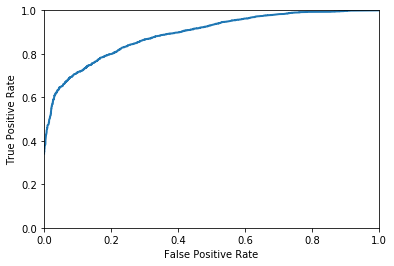

In [46]:
# Evaluate model performance using ROC
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

y_score = best_model.predict_proba(X_test[opt_features])[:,1]
fpr, tpr, th = roc_curve(y_test, y_score, pos_label=255)

plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.axis([0,1,0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

roc_auc = auc(fpr, tpr)
roc_auc